<a href="https://colab.research.google.com/github/destroSunRay/MIT_FGSM-on-MNIST/blob/main/MIT_FGSMonMNISTdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import skimage as sk
from skimage import transform
from skimage import util
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [7]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [10]:
model = Net().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [ ]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2806065397085709 Val_Loss: 0.1298774400382703
Epoch: 2 Loss: 0.10278102253971787 Val_Loss: 0.11969320818740257
Epoch: 3 Loss: 0.08204042159261131 Val_Loss: 0.09468639045349556
Epoch: 4 Loss: 0.07061903921611129 Val_Loss: 0.10375037101738381
Epoch: 5 Loss: 0.06615545523344422 Val_Loss: 0.09075731798013272
Epoch: 6 Loss: 0.06521774060726988 Val_Loss: 0.08703497137537952
Epoch: 7 Loss: 0.06216291812495868 Val_Loss: 0.08657775502876607
Epoch: 8 Loss: 0.05913283042124958 Val_Loss: 0.08276900057965197
Epoch: 9 Loss: 0.05662621514569885 Val_Loss: 0.09031727551122079
Epoch: 10 Loss: 0.056651139755470564 Val_Loss: 0.08682030115189548


In [ ]:
torch.save(model.state_dict(), 'my_model.pt')

In [14]:
model = Net().to(device)
# model.load_state_dict(torch.load('my_model.pt',map_location=torch.device('cpu')))
model.load_state_dict(torch.load('my_model.pt'))

<All keys matched successfully>

In [9]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

NameError: ignored

<Figure size 360x360 with 0 Axes>

These are the function used to transform

Added the below transformation functions that are used in later code to randomly transform the image.

In [15]:
def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def h_flip(image):
  return np.fliplr(image)

def v_flip(image) :
  return np.flipud (image)

def add_noise(image):
  return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(image,(3,3),0.1,0.2)

#I would not recommend warp shifting, because it distorts image, but can be used in many use case like
#classifying blur and non-blur images
# def warp_shift(image):
#   transform = AffineTransform(translation=(0,40)) #chose x, y values according to your convinience
#   warp_image = warp(image, transform, mode="wrap")
#   return warp_image

transformations = {
  "random rotatation": random_rotation,
  "vertical flip": v_flip,
  "horizontal flip": h_flip
  } #use dictionary to store names of functions

In [11]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

# This is my contribution
# Transformation function takes an input tensor, convert it into image make random transformations and revert it back to a tensor array
def transformation(inp):
  inp=inp.detach().cpu().numpy()

  rowz, colz, ch = len(inp[0][0]),len(inp[0][0][0]),len(inp[0])
  inp=inp[0]
  inp=(inp*255).astype(int)

  transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
  n=0
  while n <= transformation_count:
    key = random.choice(list(transformations)) #randomly choosing method to call
    inp = transformations[key](inp)
    n=n + 1

  inp=inp/255
  inp=[inp]
  inp=torch.tensor(inp)
  inp=inp.to(device)
  inp=inp.type(torch.float32)
  inp.requires_grad = True
  return inp

#Proposed method
def mitfgsm_attack(input,epsilon,data_grad): 
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [ ]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True

      if(attack=="mitfgsm"):  #The main changes to MIT-FGSM
        inp=transformation(data)    #Random Transformation of the image.
        output = model(inp)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = inp.grad.data  #data_grad produced using transformed tensor

        output = model(data)        #we are using original tensor, so that the image looks the same
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
      else:                         
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

      

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      elif attack == "mitfgsm":
        perturbed_data = mitfgsm_attack(data,epsilon,data_grad) # 
        
      # return
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


In [ ]:

accuracyValues = {
    "mitfgsm":[],
    "mifgsm":[],
    "ifgsm" : [],
    "fgsm" : []
}


<ipython-input-20-571947896126>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  inp=torch.tensor(inp)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 2820 / 10000 = 0.282
Epsilon: 0.007	Test Accuracy = 2787 / 10000 = 0.2787
Epsilon: 0.01	Test Accuracy = 2796 / 10000 = 0.2796
Epsilon: 0.02	Test Accuracy = 2783 / 10000 = 0.2783
Epsilon: 0.03	Test Accuracy = 2795 / 10000 = 0.2795
Epsilon: 0.05	Test Accuracy = 2838 / 10000 = 0.2838
Epsilon: 0.1	Test Accuracy = 2715 / 10000 = 0.2715
Epsilon: 0.2	Test Accuracy = 2295 / 10000 = 0.2295
Epsilon: 0.3	Test Accuracy = 1689 / 10000 = 0.1689


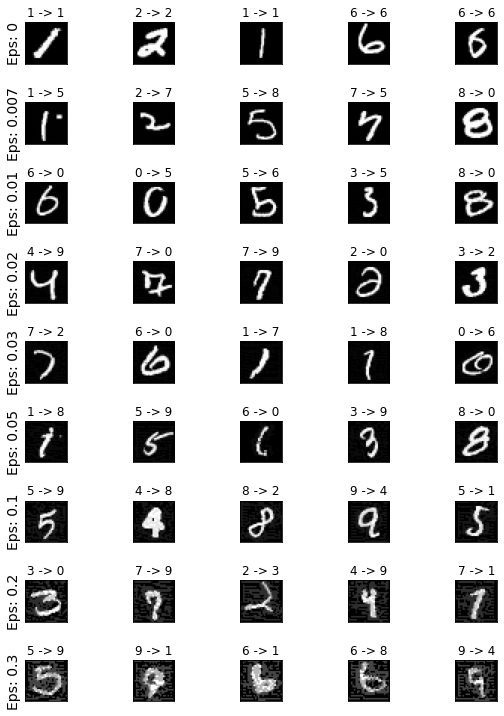

Epsilon: 0	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.007	Test Accuracy = 9673 / 10000 = 0.9673
Epsilon: 0.01	Test Accuracy = 9661 / 10000 = 0.9661
Epsilon: 0.02	Test Accuracy = 9607 / 10000 = 0.9607
Epsilon: 0.03	Test Accuracy = 9547 / 10000 = 0.9547
Epsilon: 0.05	Test Accuracy = 9398 / 10000 = 0.9398
Epsilon: 0.1	Test Accuracy = 8720 / 10000 = 0.872
Epsilon: 0.2	Test Accuracy = 5989 / 10000 = 0.5989
Epsilon: 0.3	Test Accuracy = 3220 / 10000 = 0.322


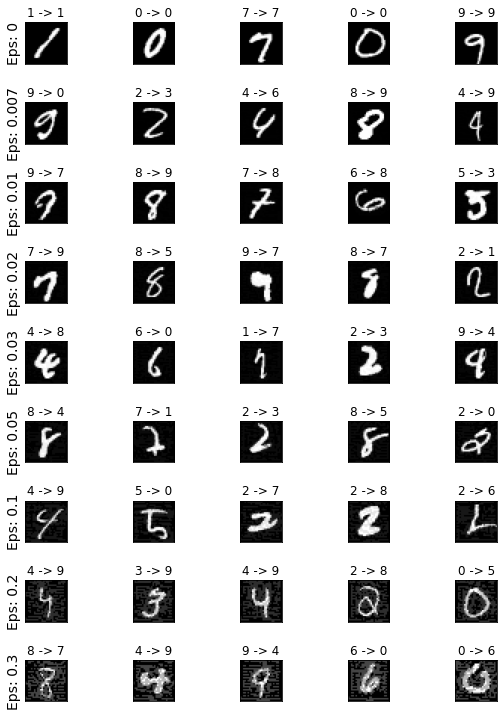

Epsilon: 0	Test Accuracy = 9694 / 10000 = 0.9694
Epsilon: 0.007	Test Accuracy = 9672 / 10000 = 0.9672
Epsilon: 0.01	Test Accuracy = 9650 / 10000 = 0.965
Epsilon: 0.02	Test Accuracy = 9604 / 10000 = 0.9604
Epsilon: 0.03	Test Accuracy = 9583 / 10000 = 0.9583
Epsilon: 0.05	Test Accuracy = 9430 / 10000 = 0.943
Epsilon: 0.1	Test Accuracy = 8719 / 10000 = 0.8719
Epsilon: 0.2	Test Accuracy = 5956 / 10000 = 0.5956
Epsilon: 0.3	Test Accuracy = 3261 / 10000 = 0.3261


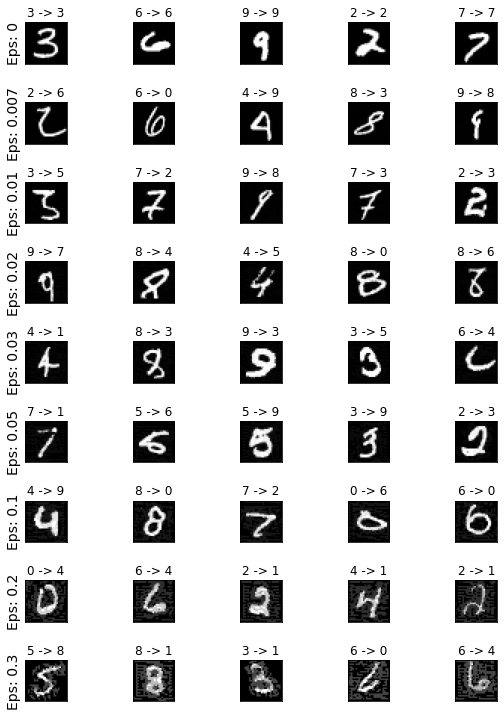

Epsilon: 0	Test Accuracy = 9686 / 10000 = 0.9686
Epsilon: 0.007	Test Accuracy = 9652 / 10000 = 0.9652
Epsilon: 0.01	Test Accuracy = 9651 / 10000 = 0.9651
Epsilon: 0.02	Test Accuracy = 9576 / 10000 = 0.9576
Epsilon: 0.03	Test Accuracy = 9549 / 10000 = 0.9549
Epsilon: 0.05	Test Accuracy = 9337 / 10000 = 0.9337
Epsilon: 0.1	Test Accuracy = 8490 / 10000 = 0.849
Epsilon: 0.2	Test Accuracy = 5231 / 10000 = 0.5231
Epsilon: 0.3	Test Accuracy = 2688 / 10000 = 0.2688


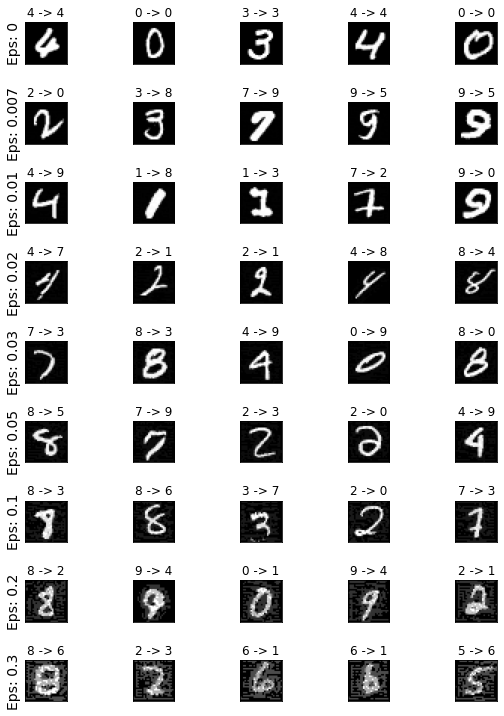

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("mitfgsm", "mifgsm","ifgsm", "fgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      # test(model, device,test_loader,eps,attack)
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  accuracyValues[attack]=accuracies
  # plt.figure(figsize=(5,5))
  # plt.plot(epsilons, accuracies, "*-")
  # plt.title(attack)
  # plt.xlabel("Epsilon")
  # plt.ylabel("Accuracy")
  # plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

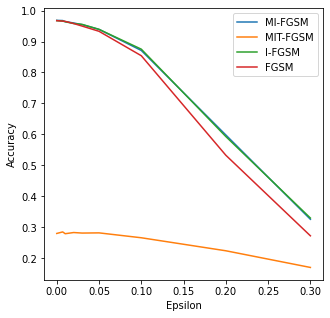

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracyValues["mifgsm"], label="MI-FGSM")
plt.plot(epsilons, accuracyValues["mitfgsm"], label="MIT-FGSM")
plt.plot(epsilons, accuracyValues["ifgsm"], label="I-FGSM")
plt.plot(epsilons, accuracyValues["fgsm"], label="FGSM")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##Defense

In [ ]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mitfgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1] 
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    # print(data)
    elif attack == "mitfgsm":
      perturbed_data = mitfgsm_attack(data,epsilon,data_grad)
      
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [ ]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  return model

In [ ]:
def attack(model,device,train_loader,epsilons):
  # for attack in ("fgsm","ifgsm","mifgsm","mitfgsm"):
  for attack in ("mitfgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,1,attack)
        accuracies.append(acc)
        examples.append(ex)
    
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

In [ ]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
model=defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)

Fitting the model...


In [ ]:
attack(model,device,train_loader,epsilons)